In [22]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scarches.models.scpoli import scPoli

import warnings
from matplotlib import rcParams
FIGSIZE=(2,2)
rcParams['figure.figsize']=FIGSIZE

Read data

In [23]:
path_before_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_before_transf.h5ad" 
path_after_correction = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_after_transf.h5ad"

In [24]:
adata_before_correction = sc.read_h5ad(path_before_correction)
adata_after_correction = sc.read_h5ad(path_after_correction)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


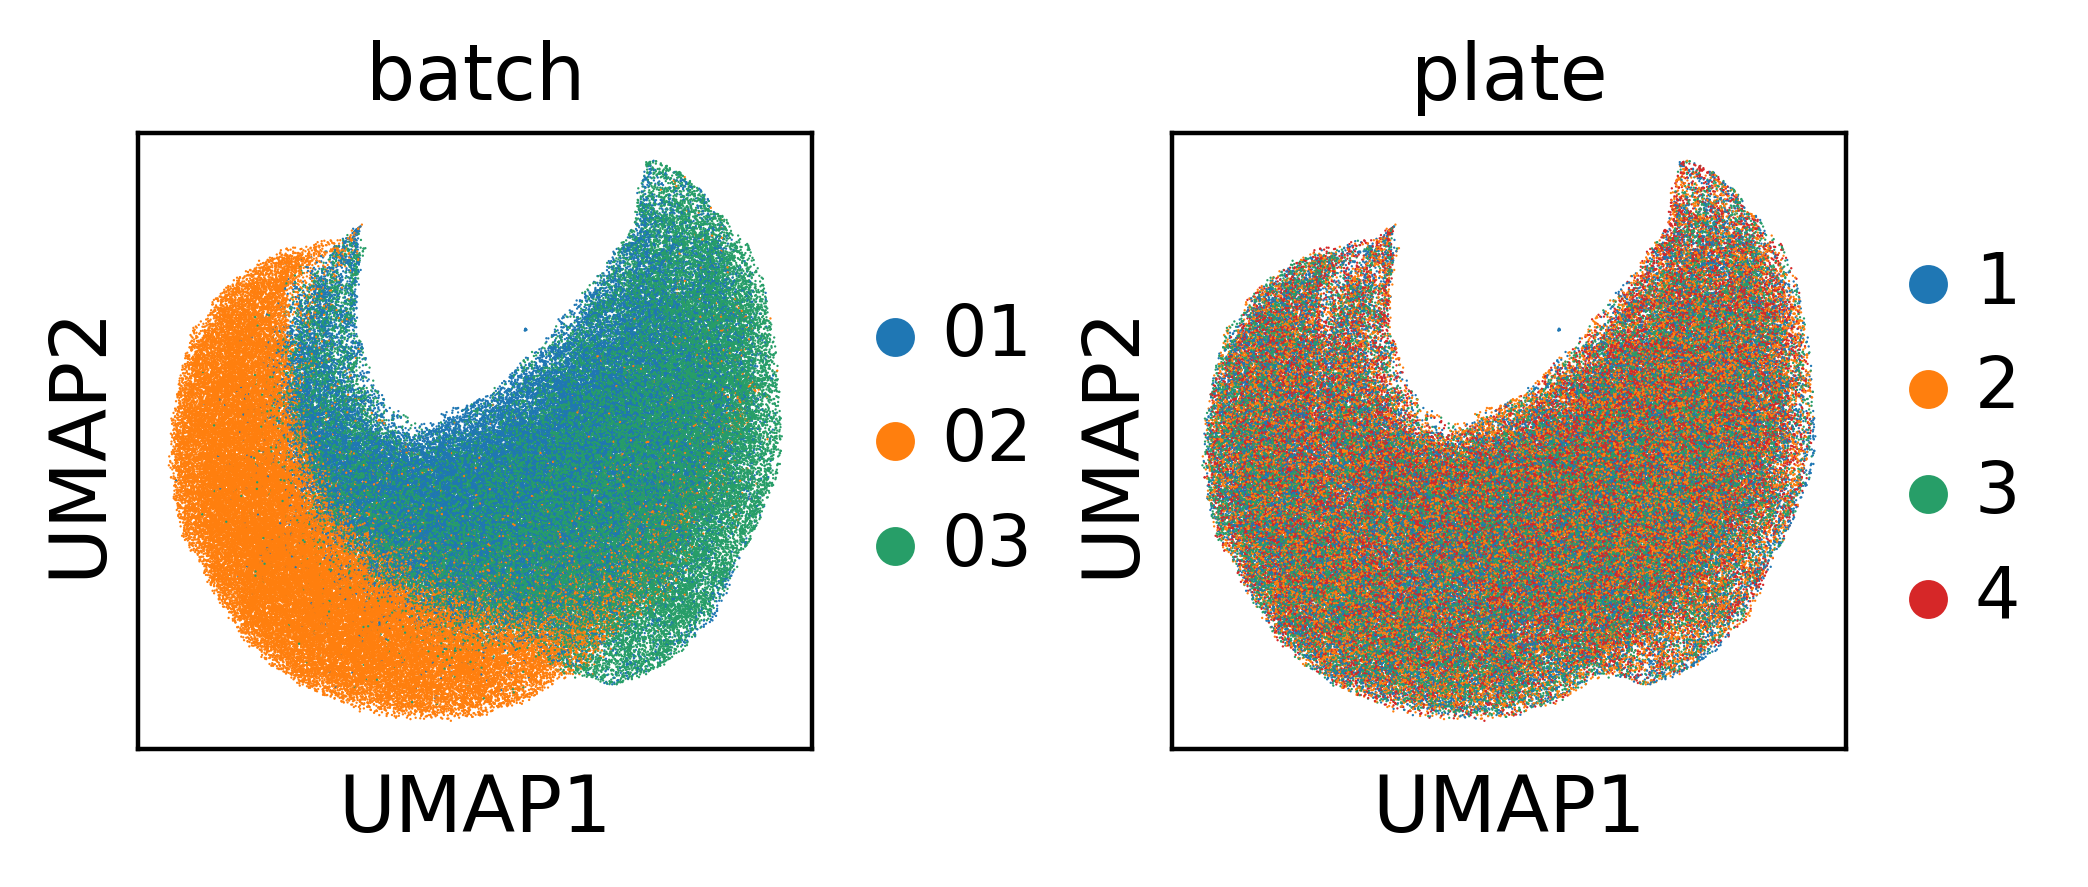

In [25]:
sc.pl.umap(adata_before_correction, color=["batch", "plate"])
plt.show()

Initialize drug labels

In [26]:
data_index = pd.read_csv('/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/rxrx1/metadata/rxrx1_df.csv', index_col=1)
compound_names = []

for row in adata_before_correction.obs.iterrows():
    batch = row[1].batch
    plate = row[1].plate
    well = row[1].well
    view = row[1]["view"]
    no = row[1].no
    file_name = f"U2OS-{batch}_{plate}_{well}_{view}_{no}"
    cpd = data_index.loc[file_name].CPD_NAME
    compound_names.append(cpd)
    
adata_before_correction.obs["compound"] = compound_names

**Train scPoli**

In [28]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

condition_key = 'batch'
cell_type_key = 'compound'

In [29]:
scpoli_model = scPoli(
    adata=adata_before_correction,
    condition_keys=condition_key,
    cell_type_keys=cell_type_key,
    embedding_dims=30,
    recon_loss='mse',
)
scpoli_model.train(
    n_epochs=100,
    pretraining_epochs=10,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)

Embedding dictionary:
 	Num conditions: [3]
 	Embedding dim: [30]
Encoder Architecture:
	Input Layer in, out and cond: 768 28 30
	Mean/Var Layer in/out: 28 10
Decoder Architecture:
	First Layer in, out and cond:  10 28 30
	Output Layer in/out:  28 768 

Initializing dataloaders
Starting training
 |█████████-----------| 45.0%  - val_loss:  434.17 - val_cvae_loss:  412.64 - val_prototype_loss:   21.53 - val_labeled_loss:    4.31
ADJUSTED LR
 |██████████----------| 52.0%  - val_loss:  436.48 - val_cvae_loss:  414.81 - val_prototype_loss:   21.68 - val_labeled_loss:    4.34
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


**Check embeddings scPoli**

In [30]:
scpoli_model.model.eval()
data_latent = scpoli_model.get_latent(
    adata_before_correction,
    mean=True
)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scarches/models/scpoli/scpoli_model.py:347: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  c = torch.tensor(label_tensor, device=device).T


In [34]:
adata_latent = sc.AnnData(data_latent)
adata_latent.obs = adata_before_correction.obs.copy()

In [36]:
sc.pp.pca(adata_latent)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


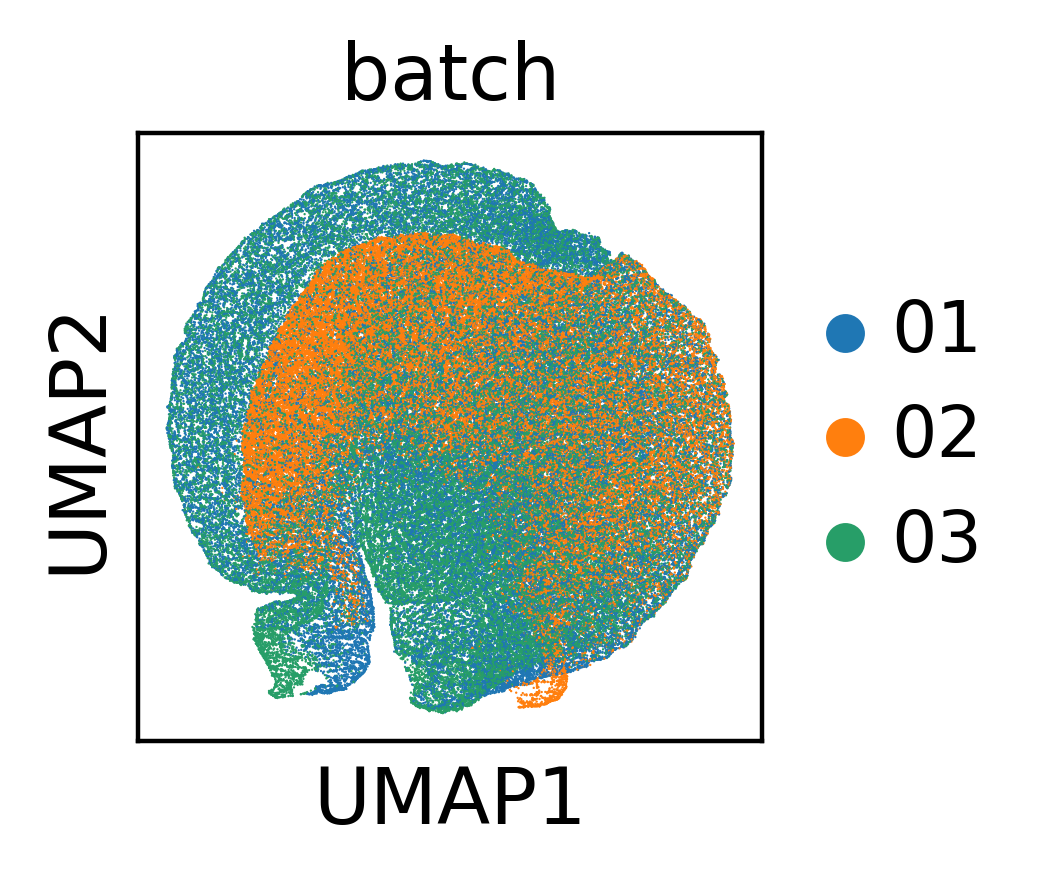

In [82]:
sc.pl.umap(adata_latent, color="batch")

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


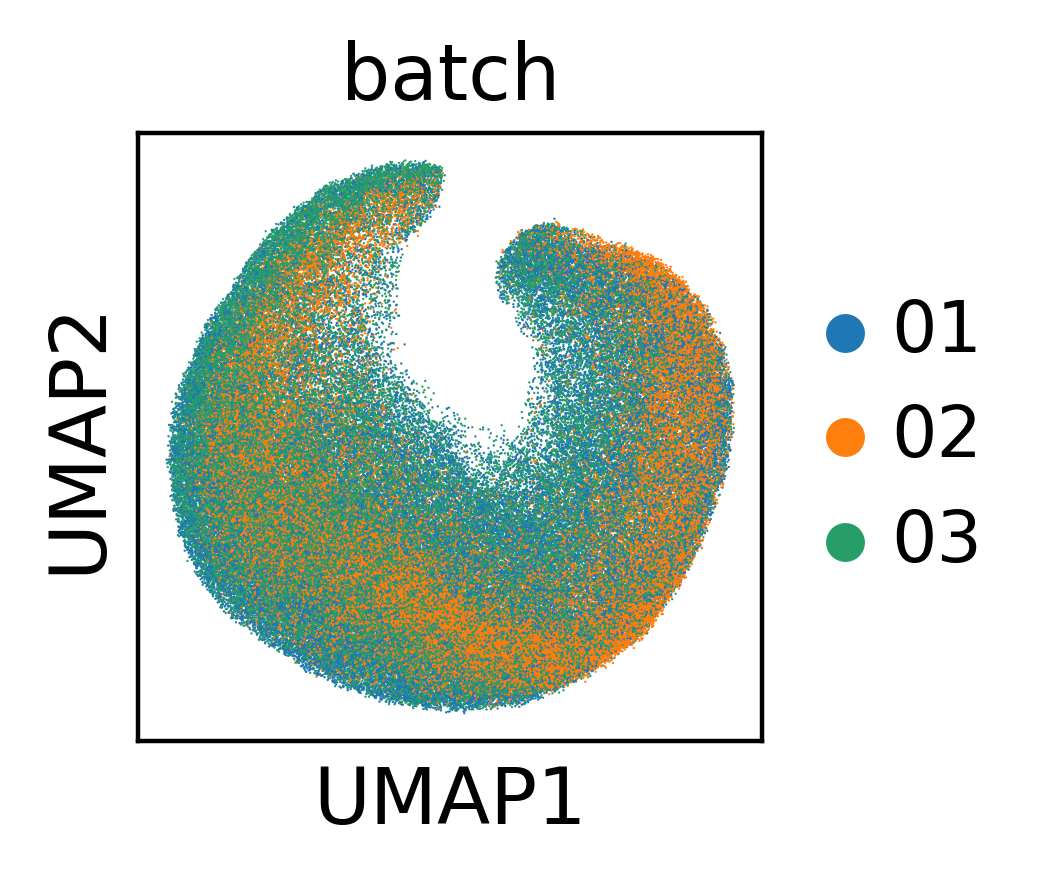

In [75]:
sc.pl.umap(adata_after_correction, color="batch")

In [59]:
for i in np.unique(adata_latent.obs.compound):
    print(i)

A4GALT
A4GNT
ABCA7
ABCA9
ABCC4
ABHD1
ABHD11
ABHD14B
ABI1
ABI3
ABLIM2
ACAA2
ACAD10
ACCS
ACOT2
ACSBG2
ACSS1
ACTL7B
ACTR5
ACTRT3
ADAP1
ADIPOR1
AGBL2
AGBL4
AGMAT
AGPAT2
AGR2
AHCYL1
AHSA1
AKAP3
AKAP9
AKR1A1
AKR1E2
ALDH1L1
ALG3
ALG9
ALYREF
AMDHD2
AMMECR1
ANAPC10
ANAPC11
ANAPC7
ANGPT4
ANGPTL4
ANGPTL6
ANKIB1
ANTXR1
AP5Z1
APC2
APH1A
APH1B
APIP
APOBEC2
APOL3
APOL4
APOL5
APPBP2
APTX
AREL1
ARFGAP2
ARHGAP10
ARHGAP11A
ARHGAP25
ARID3B
ARIH2
ARL14
ARL15
ARL6
ARL6IP5
ARMCX2
ARPC1A
ARPC5L
ARSJ
ASAP1
ASCC1
ASCC3
ASPN
ATF7
ATG13
ATG7
ATL1
ATP2C1
ATP5H
ATP6AP2
ATP6V0A4
ATP6V1H
ATP8A2
ATP8B4
AZIN1
B3GALT5
B3GNT2
B3GNT3
BAIAP2
BASP1
BCAS2
BCL11A
BCL7B
BCO2
BICC1
BLM
BMS1
BNC2
BPIFA1
BRD8
BRIP1
BTBD1
BTBD10
BTN2A3P
BTN3A3
BTNL3
BZW1
C14orf2
C1D
C1orf61
C2CD2L
C2CD5
CALCOCO2
CALY
CAP1
CAP2
CARD11
CARD6
CARM1
CARTPT
CBLL1
CBR4
CBX1
CCL26
CCL27
CCNI
CCNO
CCP110
CD244
CD2BP2
CD83
CDADC1
CDC42EP2
CDHR2
CDHR5
CDIPT
CDK2AP2
CDON
CECR1
CELF1
CEP104
CEP57
CEPT1
CFDP1
CFTR
CHAF1A
CHD9
CHERP
CHL1
CHMP6
CHPF2
CHRAC1
CHST

In [51]:
# adata_latent.write_h5ad("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/dino_featurization_project/featurized_anndata/rxrx1/rxrx1_adata_scpoli.h5ad")